### Distributed Data Analytics Lab 9

In [1]:
import findspark
findspark.init()

In [2]:
findspark.find()
import pyspark
findspark.find()

'C:\\spark'

In [3]:
from pyspark import SparkContext , SparkConf
sc = SparkContext()
# sqlContext = SQLContext(sc)

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

### Exercise 1: Apache Spark - Basics
### Exercise 1A: Basic Resilient Distributed Dataset

In [5]:
a = ["spark", "rdd", "python", "context", "create", "class"]
b = ["operation", "apache", "scala", "lambda","parallel","partition"]

In [6]:
# sc

In [20]:
rdd_a = sc.parallelize(a)
rdd_b = sc.parallelize(b)

In [18]:
rdd_a1 = rdd_a.map(lambda x: (x,1))
rdd_b1 = rdd_b.map(lambda x: (x,1))

#### 1A.1 Perform rightOuterJoin and fullOuterJoin operations

In [19]:
x1 = (rdd_a1
     .rightOuterJoin(rdd_b1)
     .map(lambda x: x[0])
    )
x1.take(10)

['scala', 'parallel', 'operation', 'apache', 'partition', 'lambda']

In [10]:
x2 = (rdd_a1
     .fullOuterJoin(rdd_b1)
     .map(lambda x: x[0])
    )
x2.take(10)

['python',
 'spark',
 'context',
 'create',
 'scala',
 'parallel',
 'operation',
 'apache',
 'partition',
 'lambda']

#### 1A.2 Using map and reduce functions to count how many times the character "s" appears in all a and b

In [11]:
(rdd_a1
 .flatMap(lambda x: list(x[0]))
 .map(lambda x: (x,1))
 .reduceByKey(lambda x, y: x + y)
 .filter(lambda x: x[0]=="s")
 .collect())

[('s', 3)]

In [12]:
(rdd_b1
 .flatMap(lambda x: list(x[0]))
 .map(lambda x: (x,1))
 .reduceByKey(lambda x, y: x + y)
 .filter(lambda x: x[0]=="s")
 .collect()
)

[('s', 1)]

In [13]:
(rdd_a1
 .union(rdd_b1)
 .map(lambda x: x[0])
 .flatMap(lambda x: list(x))
 .map(lambda x: (x,1))
 .filter(lambda x: x[0]=='s')
 .reduceByKey(lambda x, y: x + y)
 .collect()
#  .take(2)
)

[('s', 4)]

#### 1A.3 Using aggregate function to count how many times the character "s" appears in all a and b

In [14]:
(rdd_a1
 .flatMap(lambda x: list(x[0]))
 .map(lambda x: (x,1))
 .filter(lambda x: x[0]=='s')
 .aggregateByKey((0.0),
                (lambda x,y: (x+y)),
                (lambda rdd1,rdd2:(rdd1+rdd2)))
 .collect()
)

[('s', 3.0)]

In [15]:
(rdd_b1
 .flatMap(lambda x: list(x[0]))
 .map(lambda x: (x,1))
 .filter(lambda x: x[0]=='s')
 .aggregateByKey((0.0),
                (lambda x,y: (x+y)),
                (lambda rdd1,rdd2:(rdd1+rdd2)))
 .collect()
)

[('s', 1.0)]

In [16]:
(rdd_a1
 .union(rdd_b1)
 .map(lambda x: x[0])
 .flatMap(lambda x: list(x))
 .map(lambda x: (x,1))
 .filter(lambda x: x[0]=='s')
 .aggregateByKey((0.0),
                (lambda x,y: (x+y)),
                (lambda rdd1,rdd2:(rdd1+rdd2)))
 .collect()
)

[('s', 4.0)]

### Exercise 1B: Dataframes

In [24]:
from pyspark.sql.functions import mean, to_timestamp, unix_timestamp, when, col, to_date, datediff, lit, round, stddev
from pyspark.sql import SparkSession
import datetime
from matplotlib import pyplot as plt

In [25]:
spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .getOrCreate()


In [26]:
df = spark.read.json('spark/students.json')

In [27]:
print("The json dataset: ", "\n")
df.show(20)

The json dataset:  

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 

In [28]:
# 1. Replace the null value(s) in column points by the mean of all points.
df = df.na.fill(df.agg(mean('points')).collect()[0][0])

In [29]:
# 2. Replace the null value(s) in column dob and column last name by "unknown" and "--" respectively.
df = df.na.fill('unknown', 'dob')
df = df.na.fill('--', 'last_name')

In [30]:
# 3. Convert all the dates into DD-MM-YYYY format.
# https://stackoverflow.com/questions/39088473/pyspark-dataframe-convert-unusual-string-format-to-timestamp
df2 = df.select('*', to_timestamp(df.dob, 'MMMMM dd, yyyy').alias('date'))
df2 = df2.withColumn('date', when(col('date').isNull(), to_timestamp(df.dob, 'dd MMMMM yyyy')).otherwise(col('date')))
df2 = df2.withColumn('dob', unix_timestamp(col("date"), 'yyyy-MM-dd HH:mm:ss').cast("timestamp"))
df2 = df2.withColumn('dob', to_date('dob', 'dd-MM-yyyy'))
df2 = df2.drop('date')


In [31]:
# 4. Insert a new column age and calculate the current age of all students.
# https://stackoverflow.com/questions/44020818/how-to-calculate-date-difference-in-pyspark
df2 = df2.select('*', round(datediff(lit(datetime.date.today()), col('dob')) / 365, 0).alias('age'))


In [32]:
# 5. If point > 1 standard deviation of all points, then update current point to 20
grades = df2.agg({'points': 'mean'}).collect()[0][0] + df2.agg({'points': 'stddev'}).collect()[0][0]
df2 = df2.withColumn('points', when(col('points') > grades, 20).otherwise(col('points')))

In [35]:
print("Edited json dataset: ", "\n")
df2.show(15)

Edited json dataset:  

+------------------+----------+----------+---------+------+----+----+
|            course|       dob|first_name|last_name|points|s_id| age|
+------------------+----------+----------+---------+------+----+----+
|Humanities and Art|1983-10-14|      Alan|      Joe|    10|   1|36.0|
|  Computer Science|1980-09-26|    Martin|  Genberg|    20|   2|39.0|
|    Graphic Design|1982-06-12|     Athur|   Watson|    20|   3|37.0|
|    Graphic Design|1987-04-05|  Anabelle|  Sanberg|    12|   4|32.0|
|        Psychology|1978-11-01|      Kira| Schommer|    11|   5|41.0|
|          Business|1981-02-17| Christian|   Kiriam|    10|   6|38.0|
|  Machine Learning|1984-01-01|   Barbara|  Ballard|    14|   7|36.0|
|     Deep Learning|1978-01-13|      John|       --|    10|   8|41.0|
|  Machine Learning|1989-12-26|    Marcus|   Carson|    20|   9|30.0|
|           Physics|1987-12-30|     Marta|   Brooks|    11|  10|32.0|
|    Data Analytics|1975-06-12|     Holly| Schwartz|    12|  11|44

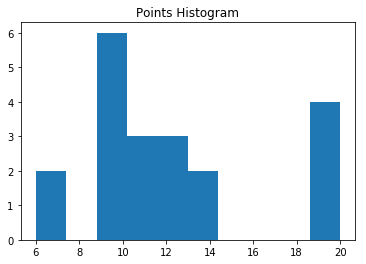

In [36]:
# 6. Create a histogram on the new points created in the task 5.
points_histogram = df2.select('points').rdd.map(lambda i: i.points).collect()
plt.hist(points_histogram)
plt.title('Points Histogram')
plt.show()


### Exercise 2: Apache Spark

In [37]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [38]:
tag_rdd = (sc
           .textFile("spark/tags.dat")
           .map(lambda x: x.split('::'))
           .map(lambda x: [int(x[0]), int(x[1]),x[2],int(x[3])])
          )
           

In [39]:
tag_rdd.take(5)

[[15, 4973, 'excellent!', 1215184630],
 [20, 1747, 'politics', 1188263867],
 [20, 1747, 'satire', 1188263867],
 [20, 2424, 'chick flick 212', 1188263835],
 [20, 2424, 'hanks', 1188263835]]

In [40]:
tag_rdd.count()

95580

In [41]:
# sc = SparkContext(appName="PrevRowDiffApp")
sqlc = SQLContext(sc)
tag_df = sqlc.createDataFrame(tag_rdd, ["UserID","MovieID","Tag","Timestamp"])

In [42]:
# tag_df.take(5)
tag_df.show()

+------+-------+--------------------+----------+
|UserID|MovieID|                 Tag| Timestamp|
+------+-------+--------------------+----------+
|    15|   4973|          excellent!|1215184630|
|    20|   1747|            politics|1188263867|
|    20|   1747|              satire|1188263867|
|    20|   2424|     chick flick 212|1188263835|
|    20|   2424|               hanks|1188263835|
|    20|   2424|                ryan|1188263835|
|    20|   2947|              action|1188263755|
|    20|   2947|                bond|1188263756|
|    20|   3033|               spoof|1188263880|
|    20|   3033|           star wars|1188263880|
|    20|   7438|              bloody|1188263801|
|    20|   7438|             kung fu|1188263801|
|    20|   7438|           Tarantino|1188263801|
|    21|  55247|                   R|1205081506|
|    21|  55253|               NC-17|1205081488|
|    25|     50|        Kevin Spacey|1166101426|
|    25|   6709|         Johnny Depp|1162147221|
|    31|     65|    

In [43]:
my_window = Window.partitionBy("UserID").orderBy(["UserID","Timestamp"])

tag_df = tag_df.withColumn("prev_Timestamp", F.lag(tag_df.Timestamp).over(my_window))
tag_df = tag_df.withColumn("diff", F.when(F.isnull(tag_df.Timestamp - tag_df.prev_Timestamp), 0)
                              .otherwise(tag_df.Timestamp - tag_df.prev_Timestamp))

tag_df.show()

+------+-------+--------------------+----------+--------------+--------+
|UserID|MovieID|                 Tag| Timestamp|prev_Timestamp|    diff|
+------+-------+--------------------+----------+--------------+--------+
|  1806|  43560|              comedy|1147983808|          null|       0|
|  1806|  43560|                kids|1147983808|    1147983808|       0|
|  1806|   7018|            language|1172157899|    1147983808|24174091|
|  1806|   7152|              nudity|1176483953|    1172157899| 4326054|
|  1806|   7152|                dark|1176483990|    1176483953|      37|
|  1806|  44709|        heartwarming|1176485185|    1176483990|    1195|
|  1806|  44199|intelligent thriller|1176485297|    1176485185|     112|
|  1806|  43936|               tense|1176485376|    1176485297|      79|
|  1806|  43928|              stupid|1176485429|    1176485376|      53|
|  1806|  42734|              clever|1176485536|    1176485429|     107|
|  1806|  40583|       confused plot|1176485722|   

In [44]:
tag_df = tag_df.withColumn("threshold_flag",  F.when(tag_df.diff>(30*3600),1)
                           .otherwise(0))
tag_df.show()

+------+-------+--------------------+----------+--------------+--------+--------------+
|UserID|MovieID|                 Tag| Timestamp|prev_Timestamp|    diff|threshold_flag|
+------+-------+--------------------+----------+--------------+--------+--------------+
|  1806|  43560|              comedy|1147983808|          null|       0|             0|
|  1806|  43560|                kids|1147983808|    1147983808|       0|             0|
|  1806|   7018|            language|1172157899|    1147983808|24174091|             1|
|  1806|   7152|              nudity|1176483953|    1172157899| 4326054|             1|
|  1806|   7152|                dark|1176483990|    1176483953|      37|             0|
|  1806|  44709|        heartwarming|1176485185|    1176483990|    1195|             0|
|  1806|  44199|intelligent thriller|1176485297|    1176485185|     112|             0|
|  1806|  43936|               tense|1176485376|    1176485297|      79|             0|
|  1806|  43928|              st

In [45]:
myPartition=Window.partitionBy(['UserID']).orderBy(tag_df['Timestamp']) 
temp = tag_df.withColumn('tag_sessions',F.sum('threshold_flag').over(myPartition))
temp.show()

+------+-------+--------------------+----------+--------------+--------+--------------+------------+
|UserID|MovieID|                 Tag| Timestamp|prev_Timestamp|    diff|threshold_flag|tag_sessions|
+------+-------+--------------------+----------+--------------+--------+--------------+------------+
|  1806|  43560|              comedy|1147983808|          null|       0|             0|           0|
|  1806|  43560|                kids|1147983808|    1147983808|       0|             0|           0|
|  1806|   7018|            language|1172157899|    1147983808|24174091|             1|           1|
|  1806|   7152|              nudity|1176483953|    1172157899| 4326054|             1|           2|
|  1806|   7152|                dark|1176483990|    1176483953|      37|             0|           2|
|  1806|  44709|        heartwarming|1176485185|    1176483990|    1195|             0|           2|
|  1806|  44199|intelligent thriller|1176485297|    1176485185|     112|             0|    

In [46]:
temp2 = temp.groupby(temp.UserID, temp.tag_sessions).count()
temp2.show()

+------+------------+-----+
|UserID|tag_sessions|count|
+------+------------+-----+
|  1806|           0|    2|
|  1806|           1|    1|
|  1806|           2|   10|
|  1806|           3|    3|
|  1806|           4|    1|
|  1806|           5|    1|
|  2040|           0|    2|
| 15437|           0|    1|
| 15663|           0|    1|
| 15846|           0|    9|
| 18295|           0|    1|
| 18295|           1|    3|
| 18730|           0|    1|
| 19141|           0|    1|
| 25649|           0|    1|
| 25649|           1|    1|
| 25649|           2|    1|
| 25649|           3|    1|
| 27919|           0|    1|
| 27919|           1|    2|
+------+------------+-----+
only showing top 20 rows



In [47]:
temp2 = temp.groupby(temp.UserID, temp.tag_sessions).count()
temp2.show()

+------+------------+-----+
|UserID|tag_sessions|count|
+------+------------+-----+
|  1806|           0|    2|
|  1806|           1|    1|
|  1806|           2|   10|
|  1806|           3|    3|
|  1806|           4|    1|
|  1806|           5|    1|
|  2040|           0|    2|
| 15437|           0|    1|
| 15663|           0|    1|
| 15846|           0|    9|
| 18295|           0|    1|
| 18295|           1|    3|
| 18730|           0|    1|
| 19141|           0|    1|
| 25649|           0|    1|
| 25649|           1|    1|
| 25649|           2|    1|
| 25649|           3|    1|
| 27919|           0|    1|
| 27919|           1|    2|
+------+------------+-----+
only showing top 20 rows



In [48]:
# temp3 = temp2.groupBy('UserID').agg({'count': 'mean'})
temp3 = temp2.groupBy('UserID').agg(F.avg('count').alias('avg_clicks'))

In [49]:
temp3.show()

+------+----------+
|UserID|avg_clicks|
+------+----------+
|  1806|       3.0|
|  2040|       2.0|
| 15437|       1.0|
| 15663|       1.0|
| 15846|       9.0|
| 18295|       2.0|
| 18730|       1.0|
| 19141|       1.0|
| 25649|       1.0|
| 27919|       1.5|
| 29018|       1.0|
| 31156|       1.0|
| 37098|       1.0|
| 39104|       1.0|
| 39713|       1.5|
| 48280|       2.0|
| 50049|       2.0|
| 55700|       1.0|
| 60016|       1.0|
| 60738|       7.0|
+------+----------+
only showing top 20 rows



In [50]:
temp3.groupBy().agg(F.avg('avg_clicks')).collect()

[Row(avg(avg_clicks)=6.86615877958277)]

In [51]:
temp3.groupBy().agg(F.stddev('avg_clicks')).collect()

[Row(stddev_samp(avg_clicks)=27.304439327892233)]

In [121]:
temp3.filter(temp3['avg_clicks']>(2*27.3 + 6.87)).collect()

[Row(UserID=2030, avg_clicks=72.0),
 Row(UserID=20729, avg_clicks=105.75),
 Row(UserID=2854, avg_clicks=64.5),
 Row(UserID=68986, avg_clicks=81.0),
 Row(UserID=61519, avg_clicks=128.0),
 Row(UserID=57022, avg_clicks=82.0),
 Row(UserID=29850, avg_clicks=80.0),
 Row(UserID=11114, avg_clicks=256.0),
 Row(UserID=15851, avg_clicks=91.0),
 Row(UserID=17044, avg_clicks=128.0),
 Row(UserID=34405, avg_clicks=126.0),
 Row(UserID=63347, avg_clicks=80.66666666666667),
 Row(UserID=33866, avg_clicks=119.0),
 Row(UserID=16289, avg_clicks=74.0),
 Row(UserID=36151, avg_clicks=71.33333333333333),
 Row(UserID=65436, avg_clicks=170.33333333333334),
 Row(UserID=29462, avg_clicks=65.0),
 Row(UserID=9316, avg_clicks=76.05),
 Row(UserID=58160, avg_clicks=272.0),
 Row(UserID=23619, avg_clicks=62.0),
 Row(UserID=12025, avg_clicks=71.0),
 Row(UserID=15896, avg_clicks=106.0),
 Row(UserID=49265, avg_clicks=110.0),
 Row(UserID=32861, avg_clicks=110.0),
 Row(UserID=24132, avg_clicks=126.0),
 Row(UserID=38848, avg_cl

### BONUS EXERCISE

In [136]:
rat_rdd = (sc
           .textFile("spark/ratings.dat")
           .map(lambda x: x.split('::'))
           .map(lambda x: [x[0], x[1],int(x[2]),int(x[3])])
          )
           

In [137]:
rat_rdd.take(5)

[['1', '1193', 5, 978300760],
 ['1', '661', 3, 978302109],
 ['1', '914', 3, 978301968],
 ['1', '3408', 4, 978300275],
 ['1', '2355', 5, 978824291]]

In [138]:
# sc = SparkContext(appName="PrevRowDiffApp")
sqlc = SQLContext(sc)
rat_df = sqlc.createDataFrame(rat_rdd, ["UserID","MovieID","Rating","Timestamp"])

In [139]:
mov_rdd = (sc
           .textFile("spark/movies.dat")
           .map(lambda x: x.split('::'))
           .map(lambda x: [x[0], x[1],x[2]])
          )

In [140]:
mov_rdd.take(5)

[['1', 'Toy Story (1995)', "Animation|Children's|Comedy"],
 ['2', 'Jumanji (1995)', "Adventure|Children's|Fantasy"],
 ['3', 'Grumpier Old Men (1995)', 'Comedy|Romance'],
 ['4', 'Waiting to Exhale (1995)', 'Comedy|Drama'],
 ['5', 'Father of the Bride Part II (1995)', 'Comedy']]

In [141]:
#MovieID::Title::Genres
sqlc = SQLContext(sc)
mov_df = sqlc.createDataFrame(mov_rdd, ["MovieID","Title","Genres"])


In [185]:
data_mov = rat_df.join(mov_df, "MovieId")

In [144]:
data_mov.show(3)

+-------+------+------+---------+--------------+---------+
|MovieID|UserID|Rating|Timestamp|         Title|   Genres|
+-------+------+------+---------+--------------+---------+
|   1090|     2|     2|978298580|Platoon (1986)|Drama|War|
|   1090|    19|     3|978300207|Platoon (1986)|Drama|War|
|   1090|    23|     3|993706407|Platoon (1986)|Drama|War|
+-------+------+------+---------+--------------+---------+
only showing top 3 rows



In [145]:
data_mov

DataFrame[MovieID: string, UserID: string, Rating: bigint, Timestamp: bigint, Title: string, Genres: string]

In [146]:
data = data_mov.rdd

In [147]:
data.take(5)

[Row(MovieID='1090', UserID='2', Rating=2, Timestamp=978298580, Title='Platoon (1986)', Genres='Drama|War'),
 Row(MovieID='1090', UserID='19', Rating=3, Timestamp=978300207, Title='Platoon (1986)', Genres='Drama|War'),
 Row(MovieID='1090', UserID='23', Rating=3, Timestamp=993706407, Title='Platoon (1986)', Genres='Drama|War'),
 Row(MovieID='1090', UserID='24', Rating=4, Timestamp=978132818, Title='Platoon (1986)', Genres='Drama|War'),
 Row(MovieID='1090', UserID='26', Rating=3, Timestamp=978146594, Title='Platoon (1986)', Genres='Drama|War')]

In [176]:
data.first()

Row(MovieID='1090', UserID='2', Rating=2, Timestamp=978298580, Title='Platoon (1986)', Genres='Drama|War')

In [67]:
## UserID::MovieID::Rating::Timestamp
textFile = sc.textFile("spark/ratings.dat")
textFile.first()

'1::1193::5::978300760'

####  Find the movie title with highest number of average ratings

In [193]:
(textFile
 .map(lambda x: x.split('::'))
 .map(lambda x: (x[1],x[2]))
 .combineByKey( lambda a: (1.0, float(a[0])),
               lambda a, b: (a[0]+1,a[1] + float(b[0])),
               lambda rdd1, rdd2: (rdd1[0]+rdd2[0], rdd1[1]+rdd2[1])
              )
 .map(lambda x: (x[0], x[1][1]/x[1][0]))
 .sortBy(lambda x: x[1]*-1)
 .take(5)
)

[('787', 5.0), ('1830', 5.0), ('3607', 5.0), ('3280', 5.0), ('989', 5.0)]

In [212]:
data_mov.filter(data_mov.MovieID == '787').show()

+-------+------+------+---------+--------------------+-----------+
|MovieID|UserID|Rating|Timestamp|               Title|     Genres|
+-------+------+------+---------+--------------------+-----------+
|    787|   149|     5|977325719|Gate of Heavenly ...|Documentary|
|    787|  2825|     5|972610193|Gate of Heavenly ...|Documentary|
|    787|  2872|     5|972423586|Gate of Heavenly ...|Documentary|
+-------+------+------+---------+--------------------+-----------+



#### The title of the movie is Gate of Heavenly

####  Find the user who has assign lowest average rating among all the users who rated more than 40 times

In [210]:
(textFile
 .map(lambda x: x.split('::'))
 .map(lambda x: (x[0],x[2]))
 .combineByKey( lambda a: (1.0, float(a[0])),
               lambda a, b: (a[0]+1,a[1] + float(b[0])),
               lambda rdd1, rdd2: (rdd1[0]+rdd2[0], rdd1[1]+rdd2[1])
              )
 .filter(lambda x: x[1][0]>40)
 .map(lambda x: (x[0], x[1][1]/x[1][0]))
 .sortBy(lambda x: x[1]*1)
 .take(5)
)

[('3598', 1.0153846153846153),
 ('4486', 1.0588235294117647),
 ('2744', 1.3043478260869565),
 ('4539', 1.815126050420168),
 ('5850', 1.8448275862068966)]